# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [4]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [15]:
df.isnull().values.any()
#df.isna().sum()

False

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [6]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [7]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [8]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [9]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [10]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [12]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0491 - val_loss: 0.9009
Epoch 2/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0466 - val_loss: 0.8983
Epoch 3/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0440 - val_loss: 0.8957
Epoch 4/1000
149/149 [==============================] - 0s 990us/step - loss: 1.0414 - val_loss: 0.8930
Epoch 5/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0388 - val_loss: 0.8903
Epoch 6/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0361 - val_loss: 0.8876
Epoch 7/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0335 - val_loss: 0.8849
Epoch 8/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0308 - val_loss: 0.8823
Epoch 9/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0282 - val_loss: 0.8797
Epoch 10/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0

149/149 [==============================] - 0s 1ms/step - loss: 0.8493 - val_loss: 0.7009
Epoch 81/1000
149/149 [==============================] - 0s 941us/step - loss: 0.8469 - val_loss: 0.6985
Epoch 82/1000
149/149 [==============================] - 0s 946us/step - loss: 0.8445 - val_loss: 0.6961
Epoch 83/1000
149/149 [==============================] - 0s 981us/step - loss: 0.8420 - val_loss: 0.6938
Epoch 84/1000
149/149 [==============================] - 0s 914us/step - loss: 0.8396 - val_loss: 0.6914
Epoch 85/1000
149/149 [==============================] - 0s 984us/step - loss: 0.8372 - val_loss: 0.6890
Epoch 86/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8348 - val_loss: 0.6866
Epoch 87/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8324 - val_loss: 0.6842
Epoch 88/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8300 - val_loss: 0.6820
Epoch 89/1000
149/149 [==============================] - 0s 1ms/step - loss: 

Epoch 159/1000
149/149 [==============================] - 0s 954us/step - loss: 0.6752 - val_loss: 0.5309
Epoch 160/1000
149/149 [==============================] - 0s 916us/step - loss: 0.6731 - val_loss: 0.5289
Epoch 161/1000
149/149 [==============================] - 0s 948us/step - loss: 0.6711 - val_loss: 0.5270
Epoch 162/1000
149/149 [==============================] - 0s 913us/step - loss: 0.6691 - val_loss: 0.5250
Epoch 163/1000
149/149 [==============================] - 0s 935us/step - loss: 0.6671 - val_loss: 0.5231
Epoch 164/1000
149/149 [==============================] - 0s 933us/step - loss: 0.6651 - val_loss: 0.5213
Epoch 165/1000
149/149 [==============================] - 0s 938us/step - loss: 0.6631 - val_loss: 0.5194
Epoch 166/1000
149/149 [==============================] - 0s 914us/step - loss: 0.6611 - val_loss: 0.5175
Epoch 167/1000
149/149 [==============================] - 0s 929us/step - loss: 0.6591 - val_loss: 0.5156
Epoch 168/1000
149/149 [======================

149/149 [==============================] - 0s 924us/step - loss: 0.5290 - val_loss: 0.3960
Epoch 237/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5273 - val_loss: 0.3945
Epoch 238/1000
149/149 [==============================] - 0s 934us/step - loss: 0.5256 - val_loss: 0.3929
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5239 - val_loss: 0.3914
Epoch 240/1000
149/149 [==============================] - 0s 915us/step - loss: 0.5222 - val_loss: 0.3899
Epoch 241/1000
149/149 [==============================] - 0s 956us/step - loss: 0.5205 - val_loss: 0.3884
Epoch 242/1000
149/149 [==============================] - 0s 926us/step - loss: 0.5188 - val_loss: 0.3869
Epoch 243/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5172 - val_loss: 0.3855
Epoch 244/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5155 - val_loss: 0.3840
Epoch 245/1000
149/149 [==============================] - 0s 1ms/step

Epoch 314/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4115 - val_loss: 0.2952
Epoch 315/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4102 - val_loss: 0.2941
Epoch 316/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4089 - val_loss: 0.2931
Epoch 317/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4077 - val_loss: 0.2921
Epoch 318/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4064 - val_loss: 0.2911
Epoch 319/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4052 - val_loss: 0.2901
Epoch 320/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4040 - val_loss: 0.2891
Epoch 321/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4027 - val_loss: 0.2881
Epoch 322/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.4015 - val_loss: 0.2871
Epoch 323/1000
149/149 [==============================] - 0s 1ms

Epoch 393/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3299 - val_loss: 0.2327
Epoch 394/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3291 - val_loss: 0.2321
Epoch 395/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3283 - val_loss: 0.2316
Epoch 396/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3275 - val_loss: 0.2310
Epoch 397/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3267 - val_loss: 0.2305
Epoch 398/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3259 - val_loss: 0.2299
Epoch 399/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3251 - val_loss: 0.2293
Epoch 400/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3244 - val_loss: 0.2288
Epoch 401/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3236 - val_loss: 0.2282
Epoch 402/1000
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.2809 - val_loss: 0.2004
Epoch 472/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2804 - val_loss: 0.2001
Epoch 473/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2800 - val_loss: 0.1999
Epoch 474/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2795 - val_loss: 0.1996
Epoch 475/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2790 - val_loss: 0.1993
Epoch 476/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2786 - val_loss: 0.1990
Epoch 477/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2781 - val_loss: 0.1988
Epoch 478/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2777 - val_loss: 0.1985
Epoch 479/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2772 - val_loss: 0.1983
Epoch 480/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

149/149 [==============================] - 0s 941us/step - loss: 0.2528 - val_loss: 0.1853
Epoch 550/1000
149/149 [==============================] - 0s 939us/step - loss: 0.2526 - val_loss: 0.1851
Epoch 551/1000
149/149 [==============================] - 0s 934us/step - loss: 0.2523 - val_loss: 0.1850
Epoch 552/1000
149/149 [==============================] - 0s 922us/step - loss: 0.2520 - val_loss: 0.1849
Epoch 553/1000
149/149 [==============================] - 0s 926us/step - loss: 0.2518 - val_loss: 0.1848
Epoch 554/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2515 - val_loss: 0.1846
Epoch 555/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2512 - val_loss: 0.1845
Epoch 556/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2510 - val_loss: 0.1844
Epoch 557/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2507 - val_loss: 0.1842
Epoch 558/1000
149/149 [==============================] - 0s 927us/st

Epoch 627/1000
149/149 [==============================] - 0s 925us/step - loss: 0.2358 - val_loss: 0.1773
Epoch 628/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2357 - val_loss: 0.1773
Epoch 629/1000
149/149 [==============================] - 0s 924us/step - loss: 0.2355 - val_loss: 0.1772
Epoch 630/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2353 - val_loss: 0.1771
Epoch 631/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2351 - val_loss: 0.1770
Epoch 632/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2350 - val_loss: 0.1769
Epoch 633/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2348 - val_loss: 0.1769
Epoch 634/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2346 - val_loss: 0.1768
Epoch 635/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2344 - val_loss: 0.1767
Epoch 636/1000
149/149 [==============================] - 0s

149/149 [==============================] - 0s 1ms/step - loss: 0.2241 - val_loss: 0.1719
Epoch 706/1000
149/149 [==============================] - 0s 955us/step - loss: 0.2239 - val_loss: 0.1718
Epoch 707/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2238 - val_loss: 0.1717
Epoch 708/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2237 - val_loss: 0.1717
Epoch 709/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2235 - val_loss: 0.1716
Epoch 710/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2234 - val_loss: 0.1716
Epoch 711/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2233 - val_loss: 0.1715
Epoch 712/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2232 - val_loss: 0.1714
Epoch 713/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2230 - val_loss: 0.1714
Epoch 714/1000
149/149 [==============================] - 0s 3ms/step - loss:

149/149 [==============================] - 0s 913us/step - loss: 0.2150 - val_loss: 0.1674
Epoch 784/1000
149/149 [==============================] - 0s 878us/step - loss: 0.2149 - val_loss: 0.1674
Epoch 785/1000
149/149 [==============================] - 0s 871us/step - loss: 0.2148 - val_loss: 0.1673
Epoch 786/1000
149/149 [==============================] - 0s 951us/step - loss: 0.2147 - val_loss: 0.1673
Epoch 787/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2146 - val_loss: 0.1672
Epoch 788/1000
149/149 [==============================] - 0s 887us/step - loss: 0.2145 - val_loss: 0.1672
Epoch 789/1000
149/149 [==============================] - 0s 878us/step - loss: 0.2144 - val_loss: 0.1671
Epoch 790/1000
149/149 [==============================] - 0s 855us/step - loss: 0.2143 - val_loss: 0.1670
Epoch 791/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2142 - val_loss: 0.1670
Epoch 792/1000
149/149 [==============================] - 0s 1ms/

Epoch 861/1000
149/149 [==============================] - 0s 945us/step - loss: 0.2077 - val_loss: 0.1635
Epoch 862/1000
149/149 [==============================] - 0s 991us/step - loss: 0.2076 - val_loss: 0.1635
Epoch 863/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2075 - val_loss: 0.1635
Epoch 864/1000
149/149 [==============================] - 0s 946us/step - loss: 0.2075 - val_loss: 0.1634
Epoch 865/1000
149/149 [==============================] - 0s 964us/step - loss: 0.2074 - val_loss: 0.1634
Epoch 866/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.1633
Epoch 867/1000
149/149 [==============================] - 0s 991us/step - loss: 0.2072 - val_loss: 0.1633
Epoch 868/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2071 - val_loss: 0.1632
Epoch 869/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2070 - val_loss: 0.1632
Epoch 870/1000
149/149 [==============================

Epoch 939/1000
149/149 [==============================] - 0s 876us/step - loss: 0.2017 - val_loss: 0.1604
Epoch 940/1000
149/149 [==============================] - 0s 872us/step - loss: 0.2016 - val_loss: 0.1604
Epoch 941/1000
149/149 [==============================] - 0s 868us/step - loss: 0.2016 - val_loss: 0.1604
Epoch 942/1000
149/149 [==============================] - 0s 897us/step - loss: 0.2015 - val_loss: 0.1603
Epoch 943/1000
149/149 [==============================] - 0s 907us/step - loss: 0.2014 - val_loss: 0.1603
Epoch 944/1000
149/149 [==============================] - 0s 966us/step - loss: 0.2013 - val_loss: 0.1603
Epoch 945/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2013 - val_loss: 0.1602
Epoch 946/1000
149/149 [==============================] - 0s 965us/step - loss: 0.2012 - val_loss: 0.1602
Epoch 947/1000
149/149 [==============================] - 0s 969us/step - loss: 0.2011 - val_loss: 0.1602
Epoch 948/1000
149/149 [========================

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

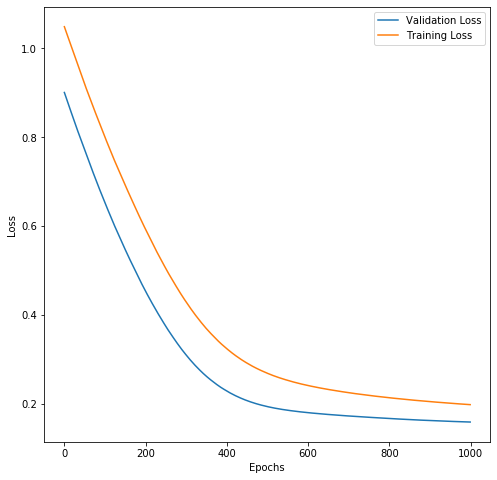

In [14]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

In [ ]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

In [ ]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)